# FairSourcing demo 
## This notebook shows all the different functionalities of the FairSourcing project

In [1]:
#Import the modules
from metrics.diversity import *
from metrics.fairness import *
from decision_maker import *
from team import *
from candidate import *

In [2]:
%load_ext autoreload
%autoreload 2

#### Generate the data, after editing your desired parameters in the params.yaml file
--> run the following in a terminal

In [3]:
# cd data\ generation/
# python generate_fake_team.py
# python generate_fake_team_objectives.py
# python generate_fake_candidates.py
# python generate_fake_recruiters.py

### Load the data
The necessary data contains: the list of employees, either one population, or segmented into teams. Each team should have at leat one manager and one recruiter. The team should have objectives and importance scores present for each social metric of interest. The teams also have a list of past candidates along with the decisions they received both at the recruiter and manager steps.

In [4]:
#Read the data files into dataframes
employees_df = pd.read_csv('data/generated_team.csv', sep=',', encoding='utf-8', index_col=0)
objectives_df = pd.read_csv('data/generated_objectives.csv', sep=',', encoding='utf-8', index_col=0)
decision_maker_df = pd.read_csv('data/generated_recruiters.csv', sep=',', encoding='utf-8', index_col=0)
candidates_df = pd.read_csv('data/generated_candidates.csv', sep=',', encoding='utf-8', index_col=0)
#has link to a job that is linked to a recruiter that has their history of decision

### Define the environment
Specify which are the considered criteria, which are the teams present in the former files and in the richness, the theoretical space for each criteria.

In [5]:
# Define important values
criteria = ['age', 'gender', 'language']
teams = ['sales', 'product', 'communication', 'finance']
richness = {'age': ['20s', '30s', '40s', '50s'], 'gender': ['M', 'F', 'O'], 'language': ['fr', 'de', 'en', 'it']}

In [6]:
# Helper functions to read the objectives dataframe, given a team, metric type and criteria, return for the first the objective and the second the importance
get_objective = lambda t, m, c: objectives_df[(objectives_df['team']== t) & (objectives_df['metric'] == m) & 
                             (objectives_df['criteria'] == c)]['target'].values[0]

get_importance = lambda t, m, c: objectives_df[(objectives_df['team']== t) & (objectives_df['metric'] == m) & 
                             (objectives_df['criteria'] == c)]['importance'].values[0]

### Create our instance
We are now ready to start experimenting. We will select one of the team, create a DecisionMaker object for the manager with the data of the corresponding employee (flagged as manager of this team). Next, we retreive the list of vacancies that this team had, and which recruiters were responsible for them. With the recruiter ids, we create a list of DecisionMaker objects (one for each recruiter). Then we create our list of Diversity metrics objects and the list of Fairness metrics object, one of each for each of the listed criterias. We can then finalize our Team object with the manager, recruiter, employees, diversity metrics, candidates and fairness metrics.

In [7]:
# Select a team and create a Team object
t = teams[0]
# Get the DecisionMakers
manager = DecisionMaker(
            str(employees_df[(employees_df['team'] == 'sales') & (employees_df['manager'] ==1)]['emp_id'].values[0]),
            t,
            'hired',
            dict(zip(criteria, employees_df[(employees_df['team'] == 'sales') & (employees_df['manager'] ==1)][criteria].values[0]))
            )
vacancies = candidates_df[candidates_df['team'] == t]['job_id'].unique()
recruiter_ids = decision_maker_df[decision_maker_df['job_id'].isin(vacancies)]['recr_id'].unique()

recruiters = [DecisionMaker(str(recr_id), t, 'transfer',
                dict(zip(criteria,decision_maker_df[decision_maker_df['recr_id'] == recr_id][criteria].values[0] ))
                ) for recr_id in recruiter_ids]

assert len(recruiter_ids) == len(recruiters)

#Create the metrics of interest
diversity_metrics = [Diversity(c, get_objective(t, 'diversity', c), get_importance(t, 'diversity', c), richness[c]) for c in criteria]

fairness_metrics= [Fairness(c, get_objective(t, 'fairness', c), get_importance(t, 'fairness', c)) for c in criteria]


team = Team(t, manager, recruiters, employees_df[employees_df['team'] == t], diversity_metrics, candidates_df[candidates_df['team'] == t], fairness_metrics)

### First step - Evaluate
We will start by inspecting the metrics for diversity and fairness criteria of the team, one by one. <br>
We also show the visualisation of the overall diversity and fairness levels.

In [8]:
def inspect_diversity(team: Team, criteria_id: int):
    """
    Helper function to compute the value of a diversity metric, visualise it, and if the objective is not met, compute the distance and difficulty.
    """
    metric = team._diversity_metrics[criteria_id]
    criteria_name = metric._criteria
    
    div, obj_reached = metric.compute(team._diversity_state)
    print('For the team ', team._team_id, ' the level of diversity in the dimension '+criteria_name+' is:', div, '. Is their goal met? ', obj_reached)
    metric.visualise(team._diversity_state)
    if not obj_reached:
        increments, reached_diversity = metric.distance(team._diversity_state)
        difficulty = metric.difficulty(div, increments, reached_diversity)
        print('In order to fill the gap, the team need to add the following profiles ', str(increments), '. This represents a difficulty of ', difficulty)

For the team  sales  the level of diversity in the dimension age is: 0.9211 . Is their goal met?  True


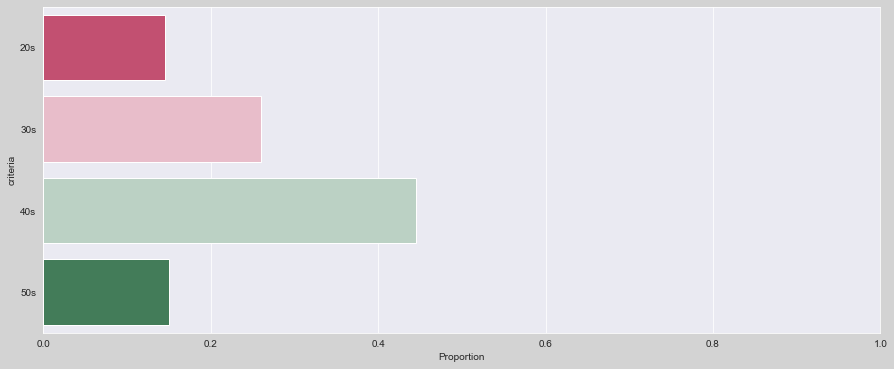

In [9]:
inspect_diversity(team, 0)

For the team  sales  the level of diversity in the dimension gender is: 0.6518 . Is their goal met?  False


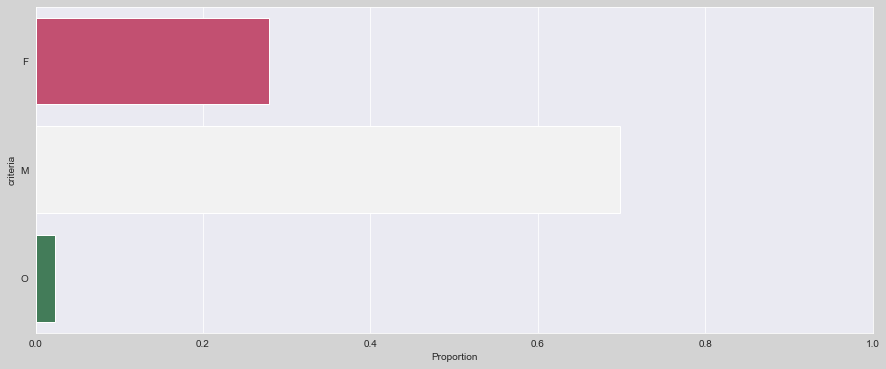

In order to fill the gap, the team need to add the following profiles  {'M': 0, 'F': 0, 'O': 213} . This represents a difficulty of  2169.0428


In [10]:
inspect_diversity(team, 1)

For the team  sales  the level of diversity in the dimension language is: 0.6114 . Is their goal met?  False


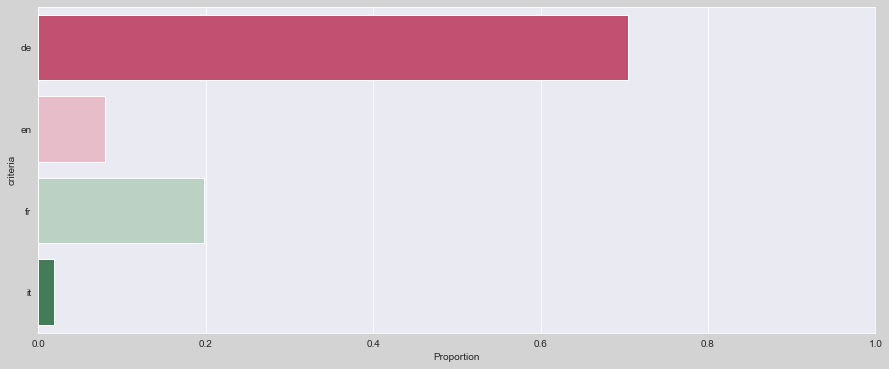

In order to fill the gap, the team need to add the following profiles  {'de': 0, 'fr': 0, 'en': 108, 'it': 289} . This represents a difficulty of  2862.2927


In [11]:
inspect_diversity(team, 2)

#### Overview of Diversity

In [12]:
#Measure Overall diversity of this team
team.compute_social_metric('Diversity')

0.7763500000000001

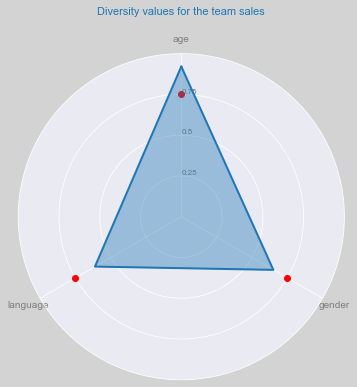

In [13]:
#Visualise the team diversity metrics
team.visualise_social_metric('Diversity')

In [14]:
def inspect_fairness(team, criteria_id, decision, richness):
    """
    Helper function to compute the value of a diversity metric, visualise it, and if the objective is not met, compute the distance and difficulty.
    """
    metric = team._fairness_metrics[criteria_id]
    criteria_name = metric._criteria
    
    fair, obj_reached = metric.compute(team._fairness_state, decision)
    print('For the team ', team._team_id, ' the level of fairness in the dimension '+criteria_name+' is:', fair, '. Is their goal met? ', obj_reached)
    metric.visualise(team._fairness_state, decision, len(richness[criteria_name]))
    if not obj_reached:
        swaps, _, reached_fairness = metric.distance(team._fairness_state, decision)
        difficulty = metric.difficulty(fair, swaps, reached_fairness)
        print('In order to fill the gap, the team need to swap the following decisions ', str(swaps), '. This represents a difficulty of ', difficulty)

For the team  sales  the level of fairness in the dimension age is: 0.9672 . Is their goal met?  True


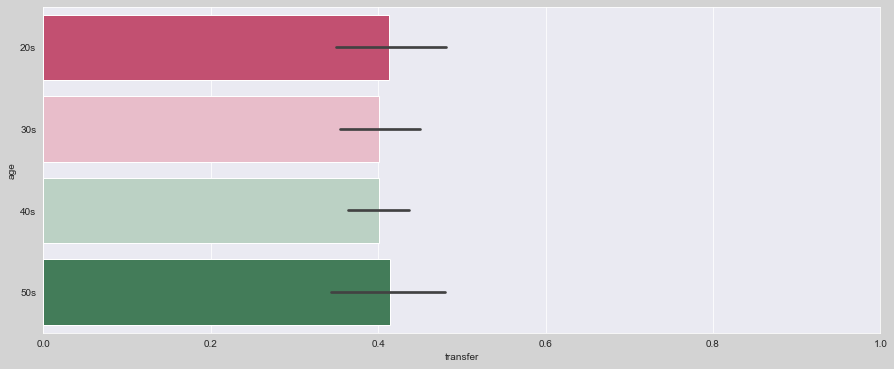

In [15]:
inspect_fairness(team, 0, 'transfer', richness)

Note: you can select which decision you would like to see

For the team  sales  the level of fairness in the dimension age is: 0.3701 . Is their goal met?  False


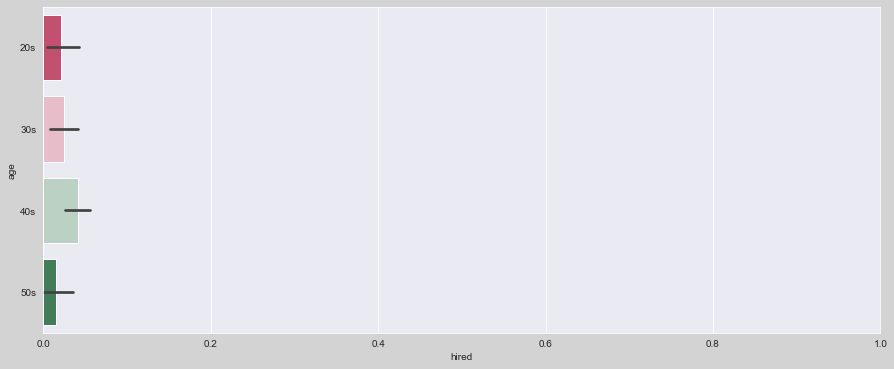

In order to fill the gap, the team need to swap the following decisions  {'30s': 2, '40s': -7, '20s': 2, '50s': 3} . This represents a difficulty of  11.6647


In [16]:
inspect_fairness(team, 0, 'hired', richness)

For the team  sales  the level of fairness in the dimension gender is: 0.7087 . Is their goal met?  False


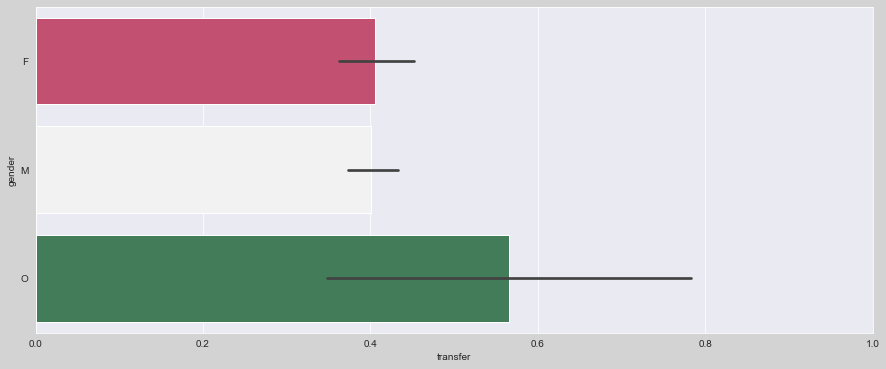

In order to fill the gap, the team need to swap the following decisions  {'M': 3, 'F': 0, 'O': -3} . This represents a difficulty of  13.6924


In [17]:
inspect_fairness(team, 1, 'transfer', richness)

For the team  sales  the level of fairness in the dimension language is: 0.7769 . Is their goal met?  False


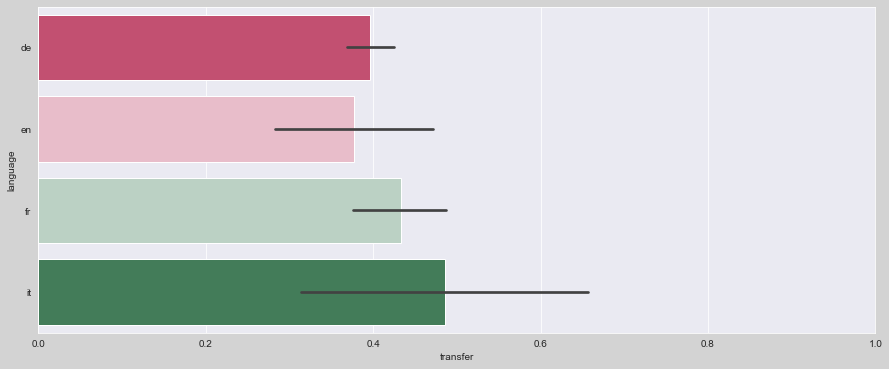

In order to fill the gap, the team need to swap the following decisions  {'de': 4, 'fr': -4, 'en': 3, 'it': -3} . This represents a difficulty of  39.5704


In [18]:
inspect_fairness(team, 2, 'transfer', richness)

#### Overview of Fairness metrics

In [19]:
#Measure Overall fairness of this team 
team.compute_social_metric('Fairness', 'transfer')

0.7903749999999999

In [20]:
#Measure Overall fairness of this team 
team.compute_social_metric('Fairness', 'hired')

0.480675

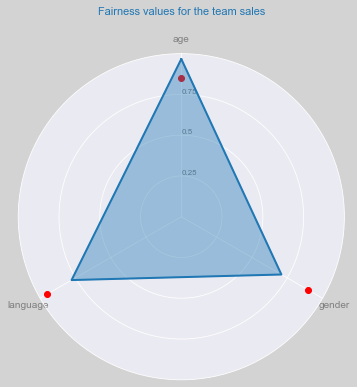

In [21]:
#Visualise the team Fairness metrics
team.visualise_social_metric('Fairness', 'transfer')

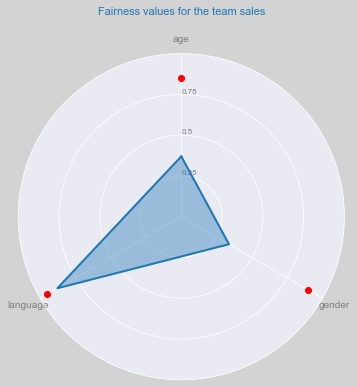

In [22]:
#Visualise the team Fairness metrics
team.visualise_social_metric('Fairness', 'hired')

### Second Step - Decision Makers
In this part we quantify the bias and visualise the pattern of decisions of a decision maker.

In [23]:
#Compute the decision landscape of the recruiters for this team
recruiter = team._recruiters[0]
# Extract the job ids of this recruiter and then the candidates to those vacancies
recr_jobs = decision_maker_df[decision_maker_df['recr_id'].astype(str) == recruiter._pers_id]['job_id'].values
recr_data = candidates_df[candidates_df.job_id.isin(recr_jobs)]

In [24]:
# Prepare the data for the manager case
manager = team._manager
mng_data = candidates_df[candidates_df['team'] == manager._team_id]

In [25]:
mmg_fairness, mng_distr = manager.get_fairness(mng_data)

In [26]:
# Compute the fairness of the decision maker and the probabilities of positive decisions per distance
recr_fairness, recr_distr = recruiter.get_fairness(recr_data)

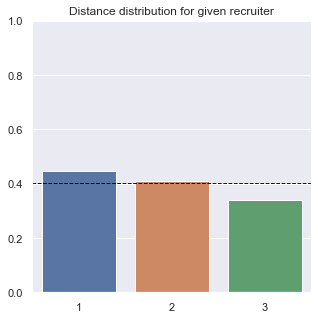

In [27]:
# Visualise the fairness
recruiter.visualise_fairness(recr_data , recr_distr)

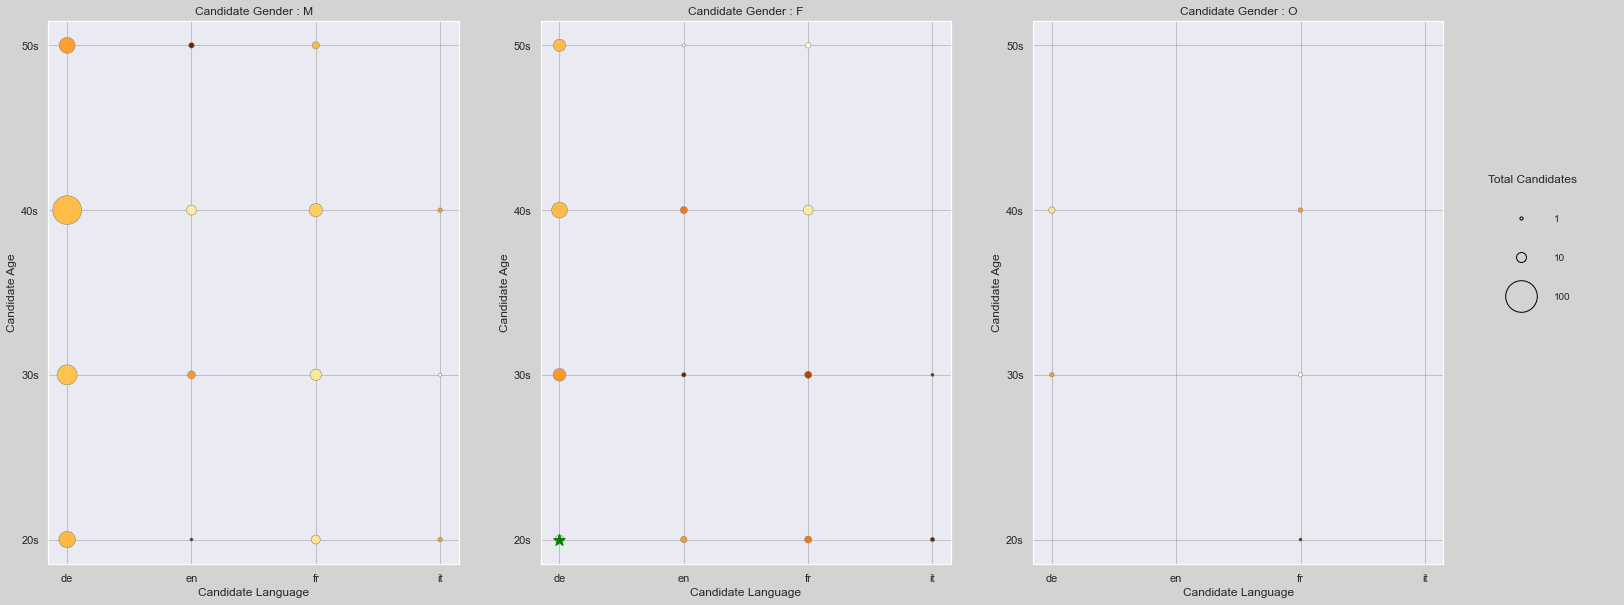

In [28]:
# Visualise the landscape of decisions
# You have one dimension across the plot, the second for the lines, the third with the columns.
# The size of the bubble shows how many candidates were in that group and the color is the probability of positive decision
# The green star locates the attributes of the recriuter.
recruiter.visualise_landscape(recr_data)

### Third Step - Candidate
In this part we first instantiate a Candidate object with a team and some set of attributes. <br>
Then we compute the impact both on the diversity and fairness metrics for this team, with the objectives and importances taken into consideration.

In [29]:
#Compute the impact of a new candidate to this team & visualize
candidate = Candidate('0', 'sales', {'age': '50s', 'gender': 'O', 'language': 'it'}, 'transfer')

div_impact, fair_impact = team.compute_cand_agg_impacts(candidate)
print('This candidate has a diversity impact = ', div_impact, ' and a fairness impact = ', fair_impact)

This candidate has a diversity impact =  0.00029999999999996696  and a fairness impact =  -0.018274999999999986


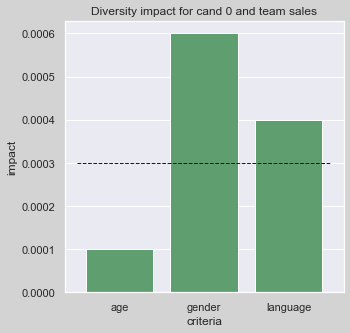

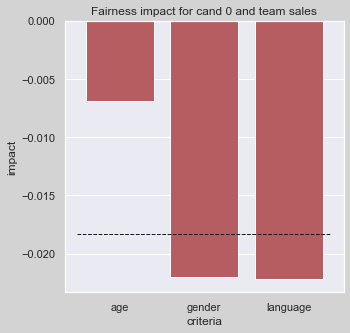

In [30]:
team.visualise_cand_impacts(candidate)

### Fourth step - Active Sourcing
The final step is an assistance to the recruiters, given a team, we compute the optimal profiles in terms of demographics to support the active sourcing.

In [31]:
#Compute the optimal next profile
team.compute_optimal_profile(richness, 'hired', n=5)

,attr,div_impact,fair_impact,tot_impact
37,"{'age': '50s', 'gender': 'M', 'language': 'de'}",-0.000025,0.031775,0.0159
41,"{'age': '50s', 'gender': 'F', 'language': 'de'}",0.000075,0.030225,0.0151
36,"{'age': '50s', 'gender': 'M', 'language': 'fr'}",0.000075,0.010550,0.0053
40,"{'age': '50s', 'gender': 'F', 'language': 'fr'}",0.000175,0.009000,0.0046
38,"{'age': '50s', 'gender': 'M', 'language': 'en'}",0.000125,0.003500,0.0018
